In [1]:
import numpy as np
import jumpdiffusion as jd
import fmlib
import matplotlib.pyplot as plt
from math import *
from grading_tools import *

# Exercises

These exercises try out the replication strategy in the jump diffusion model. I found that it was important to
use vectors throughout to represent scenarios to make the code run quickly.

Python code can be slow when it runs through loops. But if you work
in terms of large vectors each vector calculation is quick as Python uses highly efficient routines for each vector calcualtion.
So if you don't loop through scenarios and instead work with vectors your Python code should be quick.

## Exercise

Write a function to compute the delta of an option in the jump diffusion model, i.e.

$$ \frac{\partial W}{\partial S}(S_t, K)$$

Your code should be able to work with a vector of stock prices as one of the parameters. See the `jump_diffusion_call_price`
function in the library `jumpdiffusion` to see how this can be done if you find it difficult.

In [2]:
def jump_diffusion_delta( S, K, time_to_maturity, r, sigma, lbda, j):
    ### BEGIN SOLUTION
    S = np.array(S)
    term = np.ones(S.shape)
    total = np.zeros(S.shape)
    n = 0
    mu_tilde = r + lbda*(1-j)
    while np.any(abs(term)>1e-7*abs(total)):
        V = fmlib.black_scholes_delta(S,0, j**(-n)*K,time_to_maturity,mu_tilde, sigma)
        term = ((j*lbda*time_to_maturity)**n)/factorial(n) * exp( -j*lbda*time_to_maturity) * V
        total = total + term
        n = n+1
    return total
    ### END SOLUTION

In [3]:
def test_jump_diffusion_delta():
    S0 = np.array([100,110])
    h = S0*10**(-5)
    K = 110
    T = 0.5
    r = 0.02
    sigma = 0.2
    lbda = 1
    j = 0.9
    central_estimate = (jd.jump_diffusion_call_price(S0+h,K,T,r,sigma,lbda,j)-jd.jump_diffusion_call_price(S0-h,K,T,r,sigma,lbda,j))/(2*h)
    actual = jump_diffusion_delta( S0, K, T, r, sigma, lbda, j)
    np.testing.assert_almost_equal( central_estimate, actual, decimal=4 )

test_jump_diffusion_delta()
auto_marking_message()

Auto marking message: 😻 Correct


## Exercise

We will want to solve a large number of linear $2 \times 2$ simultaneousequations, one for each scenario and time point.
So that we can do this quickly write a function `solve_two_by_two` that takes vectors $(a)_i$, $(b)_i$, $(c)_i$, $(d)_i$,
$(v_1)_i$, $(v_2)_i$ all of the same length and for each value of $i$ solves the simultaneous equations

$$ a x + b y = v_1$$
$$ c x + d y = v_2$$

and returns the values $x$ and $y$.

In [4]:
def solve_two_by_two( a,b,c,d, v1, v2):
    det = a*d-b*c
    alpha = (d*v1 - b*v2)/det
    beta = (-c*v1 + a*v2)/det
    return alpha,beta

In [5]:
def test_solve_two_by_two():
    a = np.array([1,2])
    b = np.array([2,-1])
    c = np.array([3,1])
    d = np.array([3,2])
    v1 = np.array([4,5])
    v2 = np.array([3,2])
    x,y = solve_two_by_two(a,b,c,d,v1,v2)
    np.testing.assert_almost_equal( a*x + b*y, v1 )
    np.testing.assert_almost_equal( c*x + d*y, v2 )

test_solve_two_by_two()
auto_marking_message()

Auto marking message: 😻 Correct


## Exercise

Write a function that computes the values of alpha and beta given the time to maturity.
It should be able to perform the calculation for an entire vector of stock prices at once without you writing any looping code.
Your function should take advantage of your `solve_two_by_two` function to do this.

In [6]:
def compute_alpha_and_beta(S, r, sigma, lbda, j, K_prime, K, time_to_maturity ):
    ### BEGIN SOLUTION
    a = 1 
    b = jump_diffusion_delta(S,K_prime, time_to_maturity, r,sigma, lbda, j)
    v1 = jump_diffusion_delta(S,K, time_to_maturity, r,sigma, lbda, j)
    c = S - j*S
    d = jd.jump_diffusion_call_price( S, K_prime, time_to_maturity, r, sigma, lbda, j )- \
            jd.jump_diffusion_call_price( j*S, K_prime, time_to_maturity, r, sigma, lbda, j )
    v2 = jd.jump_diffusion_call_price( S, K, time_to_maturity, r, sigma, lbda, j )- \
            jd.jump_diffusion_call_price( j*S, K, time_to_maturity, r, sigma, lbda, j )
    alpha,beta = solve_two_by_two(a,b,c,d,v1,v2)
    ### END SOLUTION
    return alpha, beta

In [7]:
example_alpha, example_beta = compute_alpha_and_beta(100,0.05,0.2,0.1,0.5, 105, 110, 1)
check('59ec9c.1',example_alpha,1e-6)
check('59ec9c.2',example_beta,1e-6)
auto_marking_message()

Auto marking message: 😻 Correct


## Exercise

Perform a simulation of the replication strategy for the jump diffusion model. You should perform n_paths simulations.
For efficiency do not run through each scenario in turn, instead use vectors.

You should return two vectors: one containing the final stock price in each scenario, one containing the
final wealth of the replication strategy. If your code is correct, it should look similar to the plot given in the
slides.

For some scenarios there will be numerical difficulties caused by the determinant of the linear equations you are solving
becoming close to zero. This means that for a few scenarios in your simulation, your results will contain an error value.
In practice one could simply decide to abandon the hedging strategy when these numerical errors occurred and put all your
wealth in the risk-free account. For the sake of simplicity, I was happy just to ignore the occasional numerical error in the results.

In [8]:
def simulate_replication( S0, r, sigma, lbda, j, K_prime, K, T, lambda_prime, mu, n_steps, n_paths):
    S, t = jd.simulate_jump_diffusion( S0, T, mu, sigma, lbda, j, n_steps, n_paths )
    ### BEGIN_SOLUTION
    dt = T/n_steps
    wealth = jd.jump_diffusion_call_price( S[:,0], K, T, r, sigma, lbda, j)
    for i in range(0, n_steps):
        time_to_maturity = T - t[i]
        stock_price = S[:,i]
        hedging_option_price = jd.jump_diffusion_call_price(stock_price, K_prime, time_to_maturity, r, sigma, lbda, j )
        alpha, beta = compute_alpha_and_beta(stock_price, r, sigma, lbda, j, K_prime, K, time_to_maturity )
        bank = wealth - alpha*stock_price - beta*hedging_option_price
        new_bank = exp(r*dt)*bank
        new_stock_price = S[:,i+1]
        new_option_price = jd.jump_diffusion_call_price(new_stock_price, K_prime, time_to_maturity-dt, r, sigma, lbda, j )
        wealth = new_bank + alpha*new_stock_price + beta*new_option_price
    ST = S[:,-1]
    return ST, wealth
    ### END_SOLUTION

In [9]:
S0 = 100
r = 0.02
sigma = 0.2
lbda = 1.0
j=0.9
K_prime=100
K=110
T=0.5
lambda_prime=1.1
mu=0.08
n_steps = 1000
ST, wealth = simulate_replication(S0, r, sigma, lbda, j, K_prime, K, T, lambda_prime, mu, n_steps, 1000)

/tmp/ipykernel_3905/3602275696.py:3: RuntimeWarning: invalid value encountered in true_divide
  alpha = (d*v1 - b*v2)/det
/tmp/ipykernel_3905/3602275696.py:4: RuntimeWarning: invalid value encountered in true_divide
  beta = (-c*v1 + a*v2)/det
/tmp/ipykernel_3905/3602275696.py:3: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (d*v1 - b*v2)/det
/tmp/ipykernel_3905/3602275696.py:4: RuntimeWarning: divide by zero encountered in true_divide
  beta = (-c*v1 + a*v2)/det
/tmp/ipykernel_3905/3461614372.py:11: RuntimeWarning: invalid value encountered in subtract
  bank = wealth - alpha*stock_price - beta*hedging_option_price


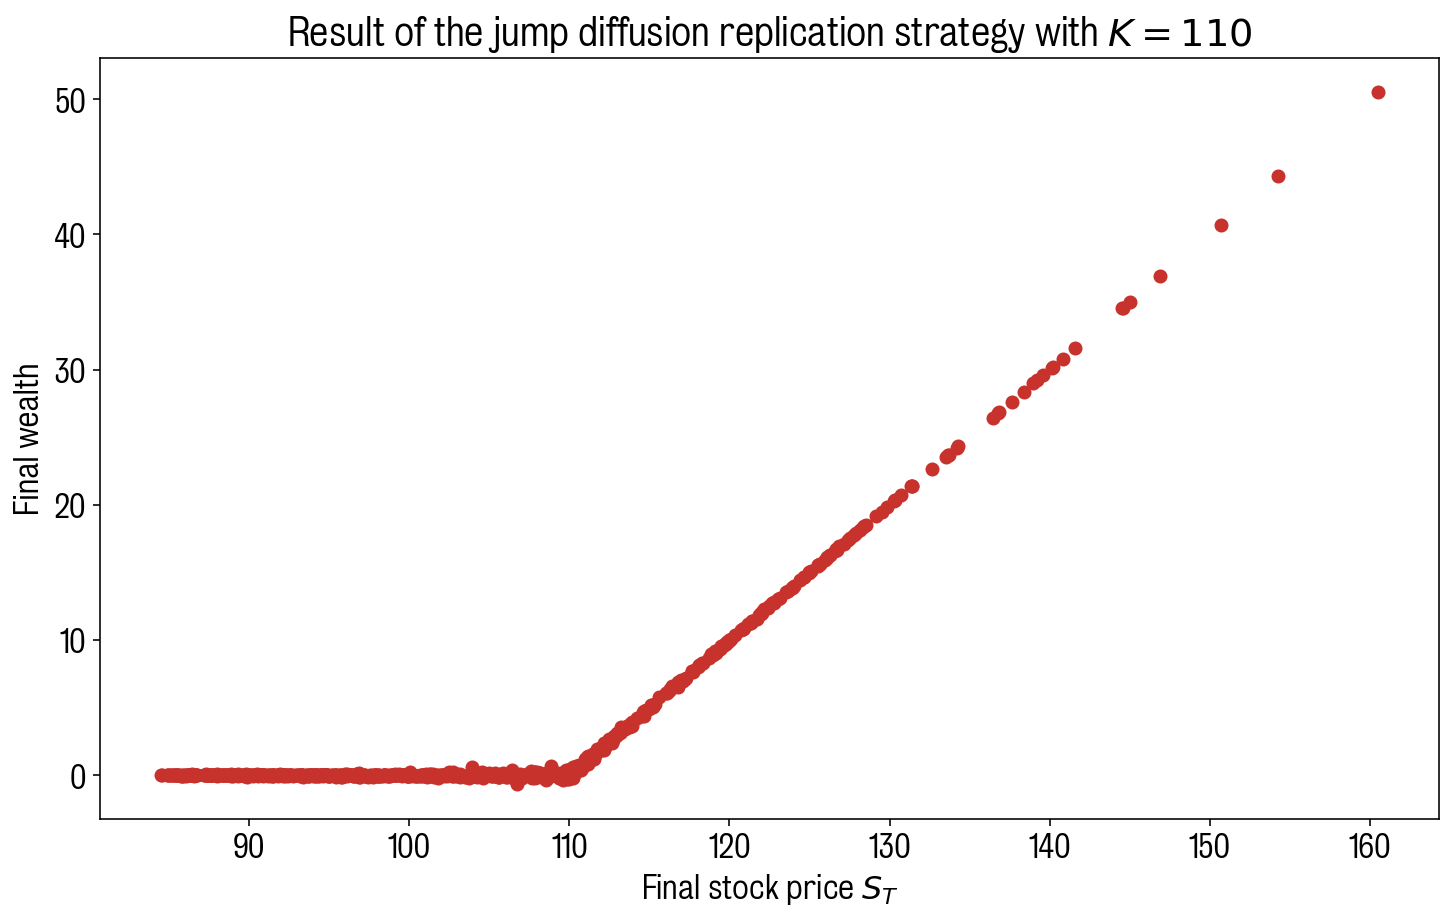

In [11]:
ax = plt.gca()
ax.scatter( ST, wealth );
ax.set_xlabel('Final stock price $S_T$')
ax.set_ylabel('Final wealth')
ax.set_title('Result of the jump diffusion replication strategy with $K=110$')
plt.savefig('replication_results.png')